# Getting Started with Kaggle Whale ID Challenge

This notebook will show you how to use this project to load, view, and work with the data for the Kaggle Whale ID challenge. We'll also set up a prediction and submission script.

In [1]:
# First we need to add the src path so we can import our sweet ass modules.
import sys
sys.path.append("../src")

In [2]:
# Import some tools.
from k_util.logger import Logger
from matplotlib import pyplot as plt
import numpy as np
import cv2
%matplotlib inline

## Load the Dataset

First download the data from Kaggle: https://www.kaggle.com/c/humpback-whale-identification/data. Unzip it, and update the paths in the `settings.yaml` file. If the file doesn't exist, it will be copied from `settings-example.yaml` when you first try to run any of the scripts. The actual `settings.yaml` file is ignored by Git, so you can edit it as you please.

 22/12 18:42  | 
 22/12 18:42  | Settings Initialized
 22/12 18:42  |    LABEL_PATH: /media/krin/DATA/data/whale/train.csv
 22/12 18:42  |    TRAIN_IMAGE_PATH: /media/krin/DATA/data/whale/train
 22/12 18:42  |    TEST_IMAGE_PATH: /media/krin/DATA/data/whale/test
 22/12 18:42  |    Example: [Sample: 00050a15a.jpg | new_whale]


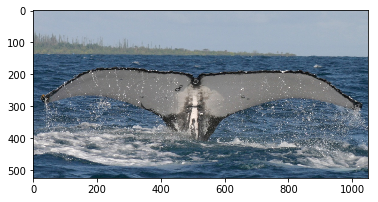

In [3]:
from util.settings import Settings
from data.loader import load_training_samples

# I have created some helper scripts to help us load the data into a structure called "Sample".
# This helps us keep things well organized and easy to use.

training_samples = load_training_samples()

# Print out an example.
sample = training_samples[3]
Logger.field("Example", sample)

# Display one of the sample images.
image = cv2.cvtColor(sample.image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Data Exploration

Now we are going to try and answer some questions about the data. This will help us to inform our strategy and how we proceed. There are the questions I want to answer.

* How big is the training/testing set?
* What does the class distribution look like?
* What can we learn from just looking at the data (positive matches and negative matches)?

Ready? Vámonos!

#### How big is the training and testing set?

In [4]:
# The first one is straightforward. We've already loaded the training set, let's just count it.
Logger.field("Number of Training Samples", len(training_samples))

# Now we'll load the testing samples as well and get information about them.
from data.loader import load_testing_samples
testing_samples = load_testing_samples()
Logger.field("Number of Testing Samples", len(testing_samples))

# While we're at it, let's also get the ratio of test:train.
data_ratio = len(testing_samples) / len(training_samples)
Logger.field("Data Ratio", data_ratio)

 22/12 18:42  |    Number of Training Samples: 25361
 22/12 18:42  |    Number of Testing Samples: 7960
 22/12 18:42  |    Data Ratio: 0.31386774969441267


#### What does the class distribution look like?
This is massively important in deciding our strategy to the challenge. If there were, say 10 well balanced classes, we could do classification. If there's a lot more, or if it is heavily imbalanced, we might have to try something else.

In [5]:
# First let's count how many different classes there are.
# For educational purposes, I'm going to do it with primitive Python methods.

class_count_map = {}  # <key: str, count: int>  | Count the number of each key.
class_sample_map = {}  # <key: str, samples: List[Sample]>  | In case we want to visualize all images for a class.

for sample in training_samples:
    key = sample.label
    
    # First time we've seen this key.
    if key not in class_count_map:
        class_count_map[key] = 0
        class_sample_map[key] = []
    
    # Update the maps.
    class_count_map[key] += 1
    class_sample_map[key].append(sample)  # We're gonna use this one later.
    
# Now we can see the number of classes.
Logger.field("Number of Classes", len(class_count_map))

 22/12 18:42  |    Number of Classes: 5005


In [6]:
# Now I want to plot the distribution.
# I don't really care about the class names, so let's just create a list with the instance count.

class_count = list(class_count_map.values())
class_count.sort(reverse=True)

# Let's print the top 5 classes.
Logger.field("Top 5 Classes", class_count[:20])

 22/12 18:42  |    Top 5 Classes: [9664, 73, 65, 62, 61, 57, 54, 51, 50, 49, 48, 47, 45, 45, 40, 40, 40, 37, 37, 37]


As you can see, there is a heavy imbalance. The first class, even though you can't tell from the above print, is actually `new_whale`. It means this whale had not been seen before by the scientist. It accounts for roughly 36% of the dataset. I will eliminate this from the list and visualize a distribution of the remaining (labelled) classes.

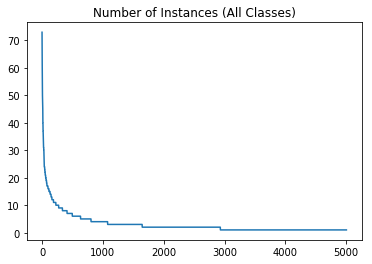

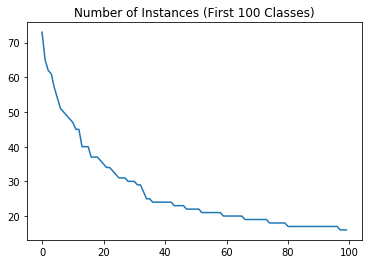

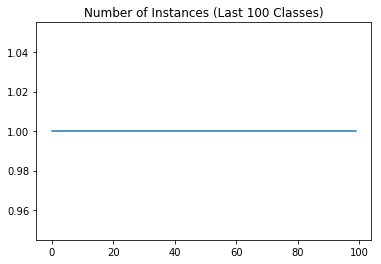

In [7]:
# Plot it.
x = range(len(class_count) - 1)
y = class_count[1:]  # Exclude New Whales
plt.title("Number of Instances (All Classes)")
plt.plot(x, y)
plt.show()

# Plot the first 100 Classes.
x = range(100)
y = class_count[1:101]
plt.title("Number of Instances (First 100 Classes)")
plt.plot(x, y)
plt.show()

# Plot the last 100 Classes.
x = range(100)
y = class_count[-100:]
plt.title("Number of Instances (Last 100 Classes)")
plt.plot(x, y)
plt.show()

In [8]:
# How many classes with only 1 sample?
n_single_sample_classes = sum([1 for i in class_count if i == 1])
Logger.field("Single Sample Classes", n_single_sample_classes)

 22/12 18:42  |    Single Sample Classes: 2073


#### What can we learn from just looking at the data?

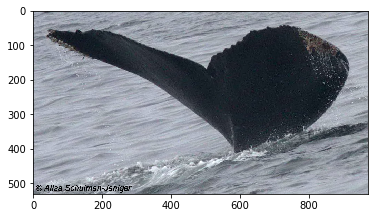

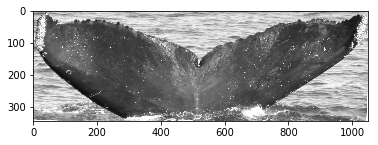

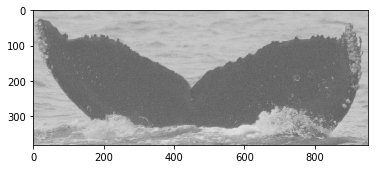

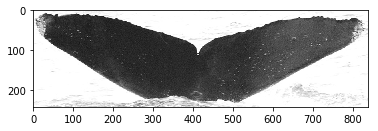

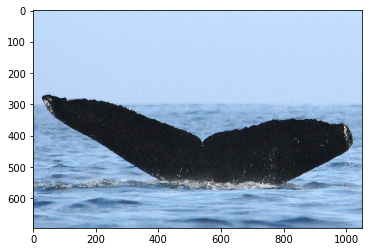

In [9]:
# First let's create a list of all the samples that are not new whales, and have more than 5 images.

good_samples = []  # This will be a list of lists.

for k, v in class_sample_map.items():
    if k == "new_whale":
        continue
    if len(v) < 5:
        continue
    good_samples.append(v)
    
# Now let's pick a random index.
import random
picked_samples = random.choice(good_samples)

# Let's visualize 5 images from this sample.
for i in range(5):
    sample = picked_samples[i]
    plt.figure()
    image = cv2.cvtColor(sample.image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

My thoughts are:
* We probably don't need the color channel.
* We need to balance the image.
* Aligning the images may also be helpful.
* Classification won't be effective here.

## Evaluating Predictions
For now, I am skipping the work of actually create a system to augment and predict these images. I will just assume there is some prediction module available (via an interface) and create a way to evaluate its performance. This is so that once we DO get to the point of making a prediction model, we'll have an easy way to measure its performance.

I have already prepared a script to (dummy) predict, but also to evaluate the samples.

In [10]:
from ai.predictor import Predictor
from eval.evaluator import evaluate

# Create a predictor instance. This is an abstract interface that we should be able to override later.
predictor = Predictor()

# Predict the samples one by one. Basically populate the predictions attribute on each sample with a list.
# This dummy function just assigns a hard coded value to each sample.
for s in training_samples:
    s.predictions = predictor.predict(s)
    
# Let's see what we get.
sample = training_samples[0]
Logger.field("Predictions", sample.predictions)

# Once we have a set of predicted samples, we can run it through the evaluator to see the score we'd get.
# n is the top-n metric. We score a hit as long as we get one of them right.
score = evaluate(training_samples, n=5)
Logger.field("Total Score", score)

 22/12 18:42  |    Predictions: ['new_whale', 'w_23a388d', 'w_9b5109b', 'w_9c506f6', 'w_0369a5c']
 22/12 18:42  |    Total Score: 0.3913489215724932


## Generating a Submission
Ok, so let's say we have now come up with a good algorithm and are scoring well on our local evaluator. We now need to generate a submission CSV to upload to Kaggle. Same again, we'll use the data structure we've created. Assuming each has already been populated with a `predictions` list, we can just write a custom CSV.

In [11]:
from util.submission_generator import generate_submission
import pandas

# Predict Testing Samples
for s in testing_samples:
    s.predictions = predictor.predict(s)

# Generate the submission based on the predictions above.
output_file = "../my_submission.csv"
generate_submission(testing_samples, output_file)

# Let's read it with Pandas! You can actually upload this file to Kaggle as your first submission.
dataframe = pandas.read_csv(output_file)
dataframe.head()

,Image,Id
0,10b1c9d01.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1,c4f4db209.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
2,ad3afe7cb.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
3,9c71d96b0.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
4,9a00976a0.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


## Good Job!
Now we've got the end-to-end process. We haven't made any real dent in the problem yet, but we're just getting started. Our goal was to understand the problem and understand our objective. We've done a benchmark submission and now we're ready to begin the real work.

* Update evaluation function to match MAP metric.
* Literature review: Siamese Networks / Contrastive Loss / Triplet Loss.
* Build a training pipeline.
* Replace Predictor function with the actual model.